In [3]:
import sys
import os

# Ruta al proyecto raíz donde está la carpeta 'scripts'
project_root = os.path.abspath('../../')  # o usa la ruta absoluta si prefieres
sys.path.append(project_root)

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
from sqlalchemy import create_engine
from scripts.remove_outliers import remove_outliers

from sqlalchemy.orm import sessionmaker
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
query = """ 
BEGIN
    DECLARE @TotalRows INT;
    DECLARE @SampleSize INT;
    DECLARE @Q1 FLOAT, @Q3 FLOAT, @IQR FLOAT;
    DECLARE @LowerBound FLOAT, @UpperBound FLOAT;

    -- Contar el total de filas
    SELECT @TotalRows = COUNT(*)
    FROM dbo.BI_GAME_SESSIONS gs
    INNER JOIN dbo.BI_CARDS crd ON crd.CARD_ID = gs.CARD_ID
    INNER JOIN dbo.BI_PLAYERS pl ON pl.PLAYER_ID = crd.PLAYER_ID
    INNER JOIN dbo.BI_PLAYERS_LEVEL_ASSIGNED pll ON pll.PLAYER_ID = pl.PLAYER_ID
    WHERE gs.INITIAL_TIME >= '2024-01-01';

    -- Calcular tamaño de muestra
    SET @SampleSize = CEILING(@TotalRows * 0.01);

    -- Calcular Q1 y Q3 usando PERCENTILE_CONT
    WITH OrderedValues AS (
        SELECT CAST(gs.INITIAL_AMOUNT AS FLOAT) AS INITIAL_AMOUNT
        FROM dbo.BI_GAME_SESSIONS gs
        INNER JOIN dbo.BI_CARDS crd ON crd.CARD_ID = gs.CARD_ID
        INNER JOIN dbo.BI_PLAYERS pl ON pl.PLAYER_ID = crd.PLAYER_ID
        INNER JOIN dbo.BI_PLAYERS_LEVEL_ASSIGNED pll ON pll.PLAYER_ID = pl.PLAYER_ID
        WHERE gs.INITIAL_TIME >= '2024-01-01'
    )
    SELECT 
        @Q1 = PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY INITIAL_AMOUNT) OVER(),
        @Q3 = PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY INITIAL_AMOUNT) OVER()
    FROM OrderedValues;

    -- Calcular límites de outliers
    SET @IQR = @Q3 - @Q1;
    SET @LowerBound = @Q1 - 1.5 * @IQR;
    SET @UpperBound = @Q3 + 1.5 * @IQR;

    -- Seleccionar muestra filtrando outliers
    SELECT TOP (@SampleSize)
           pl.PLAYER_ID,
           pl.DOB,
           pl.GENDER,
           gs.AVG_BET,
           gs.BET_TOTAL,
           gs.INITIAL_AMOUNT,
           gs.INITIAL_PROMO_AMOUNT,
           gs.FINAL_AMOUNT,
           gs.FINAL_PROMO_AMOUNT,
           gs.MACHINE_ID,
           gs.WIN_TOTAL,
           gs.GAMES_PLAYED_TOTAL,
           gs.GAMES_WON_TOTAL,
           gs.TIME_ON_DEVICE_SEC,
           pll.PLAYER_LEVEL_ID
    FROM dbo.BI_GAME_SESSIONS gs
    INNER JOIN dbo.BI_CARDS crd ON crd.CARD_ID = gs.CARD_ID
    INNER JOIN dbo.BI_PLAYERS pl ON pl.PLAYER_ID = crd.PLAYER_ID
    INNER JOIN dbo.BI_PLAYERS_LEVEL_ASSIGNED pll ON pll.PLAYER_ID = pl.PLAYER_ID
    WHERE gs.INITIAL_TIME >= '2024-01-01'
      AND gs.INITIAL_AMOUNT BETWEEN @LowerBound AND @UpperBound
    ORDER BY CHECKSUM(NEWID());
END

"""

In [6]:
load_dotenv()


server = os.getenv('SERVER')
username = os.getenv('SQL_USERNAME')
password = os.getenv('SQL_PASSWORD')

## Neza ##
database = 'ewise_BI_Ira'
connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()
df = pd.read_sql_query(query, engine)

In [7]:
df = df.loc[df['GAMES_PLAYED_TOTAL'] < 90000]

df = df.dropna()

In [8]:
from sklearn.preprocessing import StandardScaler

# 1. Seleccionar las columnas numéricas
num_cols = df.select_dtypes(include=['number']).columns

# 2. Excluir 'PLAYER_LEVEL_ID'
cols_to_scale = num_cols.drop('PLAYER_LEVEL_ID')

# 3. Instanciar el StandardScaler
scaler = StandardScaler()

# 4. Ajustar y transformar las columnas
scaled_values = scaler.fit_transform(df[cols_to_scale])

# 5. Crear nuevas columnas con sufijo '_std'
scaled_df = pd.DataFrame(scaled_values, columns=[f"{col}_std" for col in cols_to_scale], index=df.index)

# 6. Concatenar al dataframe original
df = pd.concat([df, scaled_df], axis=1)


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df ['GENDER'] = le.fit_transform(df['GENDER'])

In [10]:
df['DOB'] = pd.to_datetime(df['DOB'])
hoy = datetime.now()
df['Edad'] = hoy.year - df['DOB'].dt.year
df['Edad'] -= ((hoy.month < df['DOB'].dt.month) | 
               ((hoy.month == df['DOB'].dt.month) & 
                (hoy.day < df['DOB'].dt.day)))

bins = [18, 25, 35, 45, 55, 65, 100]  # 100 es un valor arbitrario para cubrir edades mayores a 65
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Crear la columna 'Rango_Edad'
df['Rango_Edad'] = pd.cut(df['Edad'], bins=bins, labels=labels, right=False)

le_edad = LabelEncoder()
df['Rango_Edad_le'] = le_edad.fit_transform(df['Rango_Edad'])

In [11]:
columns_selected = ['AVG_BET_std',
        'INITIAL_AMOUNT_std', 'GAMES_PLAYED_TOTAL_std',
        'GAMES_WON_TOTAL_std', 'Rango_Edad_le']
df_selected = df[columns_selected]

In [12]:
from sklearn.cluster import KMeans

wss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_selected)
    wss.append(kmeans.inertia_)


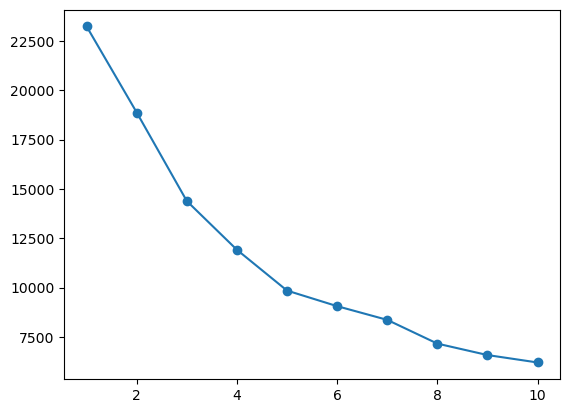

In [13]:
plt.plot(range(1, 11), wss, marker='o')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_selected)
clusters = kmeans.predict(df_selected)

df['Cluster'] = clusters

In [15]:
df_cluster_irapuato = df.groupby('Cluster').agg({
     'AVG_BET': 'mean',
    'INITIAL_AMOUNT': 'mean',
    'GAMES_PLAYED_TOTAL': 'mean',
    'GAMES_WON_TOTAL': 'mean',
    'Edad': 'mean',
}).reset_index()

df_cluster_irapuato.to_csv('../../data/cluster_irapuato.csv')